
   #  Regular Grid Variogram in Python for Engineers and Geoscientists 

## with GSLIB's GAMV Program Converted to Python

### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Irregularly Sampled Variogram Calculation in Python with GSLIB's GAMV program translated to Python, wrappers and reimplementations of other GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

This exercise demonstrates the semivariogram calculation method in Python with wrappers and reimplimentation of GSLIB methods. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize experimental semivariograms

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

I have also started to translate the GSLIB support subfunctions to Python.  Stay tuned.

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.  Overtime, more of the GSLIB programs will be translated to Python and there will be no need to have the executables.  For this workflow you will need sgsim.exe from GSLIB.com for windows and Mac OS executables from https://github.com/GeostatsGuy/GSLIB_MacOS.  

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

This was my first effort to translate the GSLIB Fortran to Python.  It was pretty easy so I'll start translating other critical GSLIB functions.  I've completed NSCORE, DECLUS, GAM and now GAMV as of now.

#### Load the required libraries

The following code loads the required libraries.

In [278]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.  These are used in the testing workflow.  

In [279]:
# Some GeostatsPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7.
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    print(str(step))
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev): 
    mean = np.average(array)
    stdev = np.std(array)  
    array = (tstdev/stdev)*(array - mean) + tmean
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var    

# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1

    sim_array = np.random.rand(nx,ny)

    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df) 

Here's the GAMV program translated to Python. Note: it was simplified to run just one experimental semivariogram at a time (in a simgle direction) and only for 2D datasets. I have applied Numba to speedup the required double loop over the data.  

In [271]:
import math                       # for trig and constants
from numba import jit             # for precompile speed up of loops with NumPy ndarrays
# GSLIB's GAMV program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
# Note simplified for 2D, semivariogram only and one direction at a time
def gamv(df,xcol,ycol,vcol,tmin,tmax,xlag,xltol,nlag,azm,atol,bandwh,isill): 
# Parameters - consistent with original GSLIB    
# df - DataFrame with the spatial data, xcol, ycol, vcol coordinates and property columns
# tmin, tmax - property trimming limits
# xlag, xltol - lag distance and lag distance tolerance
# nlag - number of lags to calculate
# azm, atol - azimuth and azimuth tolerance
# bandwh - horizontal bandwidth / maximum distance offset orthogonal to azimuth
# isill - 1 for standardize sill

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    sills = stdev**2.0
    ssq = sills
    vrmin = vr.min()
    vrmax = vr.max()
    #print('Number of Data ' + str(nd) +', Average ' + str(avg) + ' Variance ' + str(sills))

# Define the distance tolerance if it isn't already:
    if xltol < 0.0: xltol = 0.5 * xlag

# Loop over combinatorial of data pairs to calculate the variogram
    dis, vario, npp = variogram_loop(x,y,vr,xlag,xltol,nlag,azm,atol,bandwh) 

# Standardize sill to one by dividing all variogram values by the variance
    for il in range(0,nlag+2):
        if isill == 1:
            vario[il] = vario[il] / sills

# Apply 1/2 factor to go from variogram to semivariogram            
        vario[il] = 0.5 * vario[il]
    
# END - return variogram model information
    return dis, vario, npp
    
@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def variogram_loop(x,y,vr,xlag,xltol,nlag,azm,atol,bandwh):
    
# Allocate the needed memory: 
    nvarg = 1
    mxdlv = nlag + 2 # in gamv the npp etc. arrays go to nlag + 2
    dis = np.zeros(mxdlv)
    lag = np.zeros(mxdlv)
    vario = np.zeros(mxdlv)
    hm = np.zeros(mxdlv)
    tm = np.zeros(mxdlv)
    hv = np.zeros(mxdlv)
    npp = np.zeros(mxdlv)
    ivtail = np.zeros(nvarg + 2)
    ivhead = np.zeros(nvarg + 2)
    ivtype = np.ones(nvarg + 2)
    ivtail[0] = 0; ivhead[0] = 0; ivtype[0] = 0;
    
    EPSLON = 1.0e-20
    nd = len(x)
# The mathematical azimuth is measured counterclockwise from EW and
# not clockwise from NS as the conventional azimuth is:
    azmuth = (90.0-azm)*math.pi/180.0
    uvxazm = math.cos(azmuth)
    uvyazm = math.sin(azmuth)
    if atol <= 0.0:
        csatol = math.cos(45.0*math.pi/180.0)
    else:
        csatol = math.cos(atol*math.pi/180.0)

# Initialize the arrays for each direction, variogram, and lag:
    nsiz = nlag+2
    dismxs = ((float(nlag) + 0.5 - EPSLON) * xlag) ** 2  
    
# MAIN LOOP OVER ALL PAIRS:
    for i in range(0,nd):
        for j in range(0,nd):

# Definition of the lag corresponding to the current pair:
            dx  = x[j] - x[i]
            dy  = y[j] - y[i]
            dxs = dx*dx
            dys = dy*dy
            hs  = dxs + dys
            if hs <= dismxs:
                if hs < 0.0: 
                    hs = 0.0
                h = np.sqrt(hs)

# Determine which lag this is and skip if outside the defined distance
# tolerance:            
                if h <= EPSLON:
                    lagbeg = 0
                    lagend = 0
                else:
                    lagbeg = -1
                    lagend = -1
                    for ilag in range(1,nlag+1):
                        if h >= (xlag*float(ilag-1)-xltol) and h <= (xlag*float(ilag-1)+xltol): # reduced to -1
                            if lagbeg < 0: 
                                lagbeg = ilag 
                            lagend = ilag 
                if lagend >= 0: 

# Definition of the direction corresponding to the current pair. All
# directions are considered (overlapping of direction tolerance cones
# is allowed):

# Check for an acceptable azimuth angle:
                    dxy = np.sqrt(max((dxs+dys),0.0))
                    if dxy < EPSLON:
                        dcazm = 1.0
                    else:
                        dcazm = (dx*uvxazm+dy*uvyazm)/dxy

# Check the horizontal bandwidth criteria (maximum deviation 
# perpendicular to the specified direction azimuth):
                    band = uvxazm*dy - uvyazm*dx
                  
# Apply all the previous checks at once to avoid a lot of nested if statements
                    if (abs(dcazm) >= csatol) and (abs(band) <= bandwh):
# Check whether or not an omni-directional variogram is being computed:
                        omni = False
                        if atol >= 90.0: omni = True

# For this variogram, sort out which is the tail and the head value:
                        iv = 0  # hardcoded just one varioigram
                        it = ivtype[iv]
                        if dcazm >= 0.0:
                            vrh   = vr[i]
                            vrt   = vr[j]
                            if omni:
                                vrtpr = vr[i]
                                vrhpr = vr[j]
                        else:
                            vrh   = vr[j]
                            vrt   = vr[i]
                            if omni:
                                vrtpr = vr[j]
                                vrhpr = vr[i]

# Reject this pair on the basis of missing values:

# Data was trimmed at the beginning

# The Semivariogram (all other types of measures are removed for now)
                        for il in range(lagbeg,lagend+1):
                            npp[il] = npp[il] + 1
                            dis[il] = dis[il] + h
                            tm[il]  = tm[il]  + vrt
                            hm[il]  = hm[il]  + vrh
                            vario[il] = vario[il] + ((vrh-vrt)*(vrh-vrt))
                            if(omni):
                                npp[il]  = npp[il]  + 1.0
                                dis[il] = dis[il] + h
                                tm[il]  = tm[il]  + vrtpr
                                hm[il]  = hm[il]  + vrhpr
                                vario[il] = vario[il] + ((vrhpr-vrtpr)*(vrhpr-vrtpr))
                                
# Get average values for gam, hm, tm, hv, and tv, then compute
# the correct "variogram" measure:
    for il in range(0,nlag+2):
        i = il
        if npp[i] > 0:
            rnum   = npp[i]
            dis[i] = dis[i] / (rnum)
            vario[i] = vario[i] / (rnum)
            hm[i]  = hm[i]  / (rnum)
            tm[i]  = tm[i]  / (rnum)
    
    return dis, vario, npp


Here's a simple test of the GAMV code with visualizations to check the results including the gridded data pixelplt, histogram and experimental semivariograms in 4 directions.

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [282]:
os.chdir("c:/PGE337")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a 2D spatial model

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction to ensure we have a reasonable mean and spread for our feature's distribution, assumed to be Porosity (e.g. no negative values) while retaining the Gaussian distribution.  Any transform could be applied at this point.  We are keeping this workflow simple. *This is our truth model that we will sample*.

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

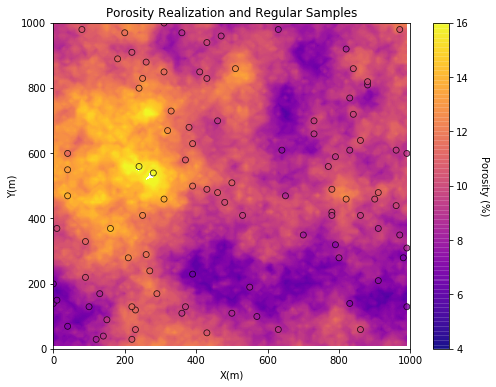

In [246]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74073                                                     # random number seed  for stochastic simulation    
vario = make_variogram(0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500)
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,vario,"Por")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
sampling_ncell = 10                                              # sample every 10th node from the model
#samples = regular_sample(sim,xmin,xmax,ymin,ymax,sampling_ncell,30,30,'Realization')
#samples_cluster = samples.drop([80,79,78,73,72,71,70,65,64,63,61,57,56,54,53,47,45,42]) # this removes specific rows (samples)
#samples_cluster = samples_cluster.reset_index(drop=True)         # we reset and remove the index (it is not sequential anymore)
samples = random_sample(sim,xmin,xmax,ymin,ymax,cell_size,100,"Por")
locpix(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples,'X','Y','Por','Porosity Realization and Regular Samples','X(m)','Y(m)','Porosity (%)',cmap,"Por_Samples")

Below I calculate the isotropic, 000 and 090 directional experimental semivariograms from our sample set.  Then the variograms are visualized together on the same variogram plot.

In [ ]:
tmin = -9999.; tmax = 9999.
lagiso, varioiso, nppiso = gamv(samples,'X','Y','Por',tmin,tmax,xlag = 100,xltol = 50,nlag = 10,azm = 0,atol = 90.0,bandwh = 9999,isill = 1) 
lag000, vario000, npp000 = gamv(samples,'X','Y','Por',tmin,tmax,xlag = 100,xltol = 50,nlag = 10,azm = 0,atol = 22.5,bandwh = 9999,isill = 1) 
lag090, vario090, npp090 = gamv(samples,'X','Y','Por',tmin,tmax,xlag = 100,xltol = 50,nlag = 10,azm = 90,atol = 22.5,bandwh = 9999,isill = 1) 

plt.subplot(121)
locpix_st(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples,'X','Y','Por','Porosity Realization and Random Samples','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
plt.scatter(lagiso,varioiso,s=nppiso/len(samples),marker='x',color = 'black',label = 'Iso')
plt.scatter(lag000,vario000,s=npp000/len(samples),marker='o',color = 'blue',label = '000')
plt.scatter(lag090,vario090,s=npp090/len(samples),marker='o',color = 'green',label = '090')
plt.plot([0,1000],[1.0,1.0],color = 'black')
plt.xlabel('Lag Distance(m)')
plt.ylabel('Semivariogram')
plt.title('Iregular Samples Experimental Variograms')
plt.ylim(0,1.5)
plt.xlim(0,1000)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::], labels[::])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3)
plt.show()

Here's the gamv program without the numba acceleration, just incase that is helpful.  Warning it is quite slow with more than a couple hundred data samples.

In [281]:
import math
# GSLIB's GAM program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
def gamv(df,xcol,ycol,vcol,tmin,tmax,xlag,xltol,nlag,azm,atol,isill): 
# Parameters - consistent with original GSLIB    
# array - 2D gridded data / model
# tmin, tmax - property trimming limits
# xsiz, ysiz - grid cell extents in x and y directions
# ixd, iyd - lag offset in grid cells
# nlag - number of lags to calculate
# isill - 1 for standardize sill
#

    nvarg = 1   # for mulitple variograms repeat the program
    nxy = nx*ny
    mxdlv = nlag + 2 # in gamv the npp etc. arrays go to nlag + 2
    dip = 0.0; dtol = 1.0   # hard code for 2D for now
    EPSLON = 1.0e-20
    bandwh = 1.0e20
    bandwd = 1.0e20

# Allocate the needed memory:   
    dis = np.zeros(mxdlv)
    lag = np.zeros(mxdlv)
    vario = np.zeros(mxdlv)
    hm = np.zeros(mxdlv)
    tm = np.zeros(mxdlv)
    hv = np.zeros(mxdlv)
    npp = np.zeros(mxdlv)
    ivtail = np.zeros(nvarg + 2)
    ivhead = np.zeros(nvarg + 2)
    ivtype = np.ones(nvarg + 2)
    ivtail[0] = 0; ivhead[0] = 0; ivtype[0] = 0;

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol]
    y = df_extract[ycol]
    vr = df_extract[vcol]

# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    sills = stdev**2.0
    ssq = sills
    vrmin = vr.min()
    vrmax = vr.max()
    #print('Number of Data ' + str(nd) +', Average ' + str(avg) + ' Variance ' + str(sills))

# Define the distance tolerance if it isn't already:
    if xltol < 0.0: xltol = 0.5 * xlag

# Removed loop over directions
        
# The mathematical azimuth is measured counterclockwise from EW and
# not clockwise from NS as the conventional azimuth is:
    azmuth = (90.0-azm)*math.pi/180.0
    uvxazm = math.cos(azmuth)
    uvyazm = math.sin(azmuth)
    if atol <= 0.0:
        csatol = math.cos(45.0*math.pi/180.0)
    else:
        csatol = math.cos(atol*math.pi/180.0)

# The declination is measured positive down from vertical (up) rather
# than negative down from horizontal:

    declin = (90.0-dip)*math.pi/180.0
    uvzdec = math.cos(declin)
    uvhdec = math.sin(declin)
    if dtol <= 0.0:
        csdtol = math.cos(45.0*math.pi/180.0)
    else:
        csdtol = math.cos(dtol*math.pi/180.0)

# Initialize the arrays for each direction, variogram, and lag:
    nsiz = nlag+2
    dismxs = ((float(nlag) + 0.5 - EPSLON) * xlag) ** 2  
    
# MAIN LOOP OVER ALL PAIRS:

    irepo = max(1,min((nd/10),1000))
    for i in range(0,nd):
#        if((int(i/irepo)*irepo) == i): 
#            print( '   currently on seed point ' + str(i) + ' of '+ str(nd))
        for j in range(0,nd):

# Definition of the lag corresponding to the current pair:
            dx  = x[j] - x[i]
            dy  = y[j] - y[i]
            dxs = dx*dx
            dys = dy*dy
            hs  = dxs + dys
            if hs <= dismxs:
                if hs < 0.0: 
                    hs = 0.0
                h = np.sqrt(hs)

# Determine which lag this is and skip if outside the defined distance
# tolerance:         
                if h <= EPSLON:
                    lagbeg = 0
                    lagend = 0
                else:
                    lagbeg = -1
                    lagend = -1
                    for ilag in range(1,nlag+1):
                        if h >= (xlag*float(ilag-1)-xltol) and h <= (xlag*float(ilag-1)+xltol): # reduced to -1
                            if lagbeg < 0: 
                                lagbeg = ilag 
                            lagend = ilag 
                if lagend >= 0: 

# Definition of the direction corresponding to the current pair. All
# directions are considered (overlapping of direction tolerance cones
# is allowed):

# Check for an acceptable azimuth angle:
                    dxy = np.sqrt(max((dxs+dys),0.0))
                    if dxy < EPSLON:
                        dcazm = 1.0
                    else:
                        dcazm = (dx*uvxazm+dy*uvyazm)/dxy

# Check the horizontal bandwidth criteria (maximum deviation 
# perpendicular to the specified direction azimuth):
                    band = uvxazm*dy - uvyazm*dx
                  
# Apply all the previous checks at once to avoid a lot of nested if statements
                    if (abs(dcazm) >= csatol) and (abs(band) <= bandwh):
# Check whether or not an omni-directional variogram is being computed:
                        omni = False
                        if atol >= 90.0: omni = True

# For this variogram, sort out which is the tail and the head value:
                        iv = 0  # hardcoded just one varioigram
                        it = ivtype[iv]
                        if dcazm >= 0.0:
                            vrh   = vr[i]
                            vrt   = vr[j]
                            if omni:
                                vrtpr = vr[i]
                                vrhpr = vr[j]

                        else:
                            vrh   = vr[j]
                            vrt   = vr[i]
                            if omni:
                                vrtpr = vr[j]
                                vrhpr = vr[i]

# Reject this pair on the basis of missing values:

# Data was trimmed at the beginning

# The Semivariogram:
                        for il in range(lagbeg,lagend+1):
                            npp[il] = npp[il] + 1
                            dis[il] = dis[il] + h
                            tm[il]  = tm[il]  + vrt
                            hm[il]  = hm[il]  + vrh
                            vario[il] = vario[il] + ((vrh-vrt)*(vrh-vrt))
                            if(omni):
                                npp[il]  = npp[il]  + 1.0
                                dis[il] = dis[il] + h
                                tm[il]  = tm[il]  + vrtpr
                                hm[il]  = hm[il]  + vrhpr
                                vario[il] = vario[il] + ((vrhpr-vrtpr)*(vrhpr-vrtpr))


# Get average values for gam, hm, tm, hv, and tv, then compute
# the correct "variogram" measure:

    for il in range(0,nlag+2):
        i = il
        if npp[i] > 0:
            rnum   = npp[i]
            dis[i] = dis[i] / (rnum)
            vario[i] = vario[i] / (rnum)
            hm[i]  = hm[i]  / (rnum)
            tm[i]  = tm[i]  / (rnum)

# Attempt to standardize:

            if isill == 1:
                vario[i] = vario[i] / sills

# semivariogram            
            vario[i] = 0.5 * vario[i]
    
    return dis, vario, npp

I hope you find this code and demonstration useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

**Michael Pyrcz**, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On Twitter I'm the **GeostatsGuy** and on YouTube my lectures are on the channel, **GeostatsGuy Lectures**.